In [299]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from tabulate import tabulate

In [300]:
tickers = {'S&P 500': '^GSPC', 'NASDAQ': '^IXIC', 'Nifty 50': '^NSEI'}
start_date = '2000-01-01'
end_date = '2025-07-20'

price_data = pd.DataFrame()

for name, ticker in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date)

    if df.empty:
        print(f" Warning: No data found for {name} ({ticker}), skipping.")
        continue

    df = df[['Close']].rename(columns={'Close': name})
    price_data = pd.concat([price_data, df], axis=1)

/var/folders/fn/z7ws07_d7wxbd0srcdtdkt6m0000gp/T/ipykernel_87402/2008985835.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/fn/z7ws07_d7wxbd0srcdtdkt6m0000gp/T/ipykernel_87402/2008985835.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/fn/z7ws07_d7wxbd0srcdtdkt6m0000gp/T/ipykernel_87402/2008985835.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [301]:
if price_data.empty:
    raise ValueError("No valid data downloaded")

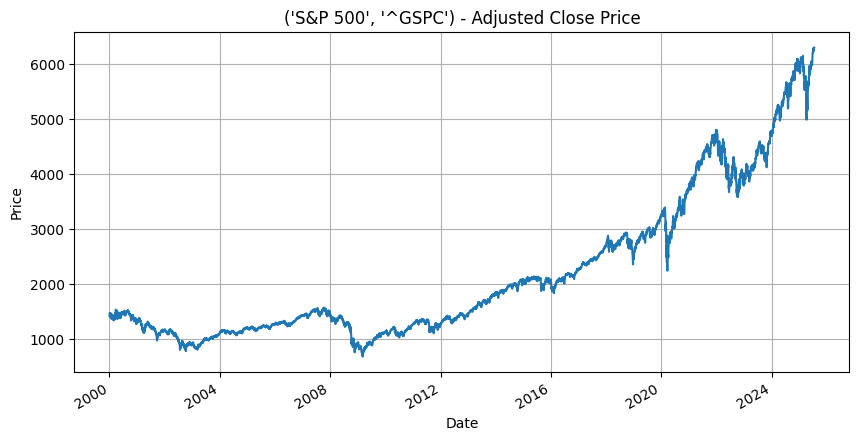

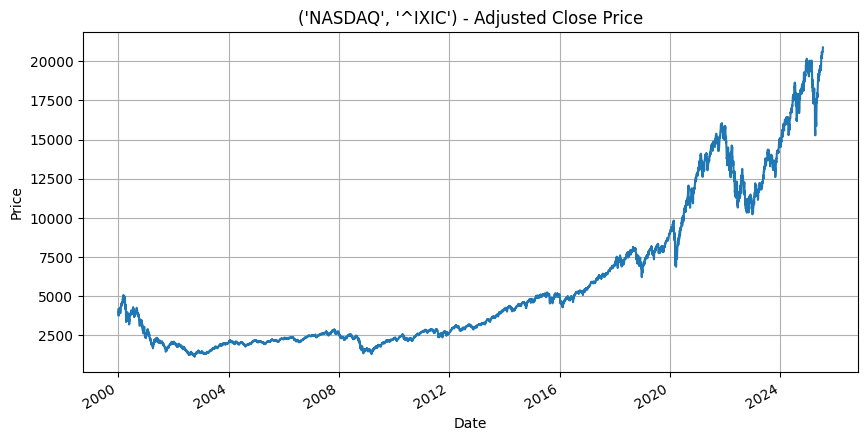

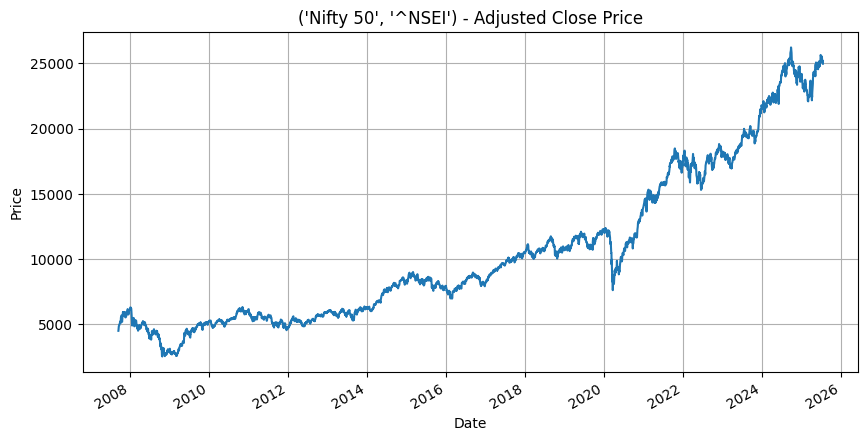

In [302]:
for column in price_data.columns:
    plt.figure(figsize=(10, 5))
    price_data[column].dropna().plot(title=f"{column} - Adjusted Close Price")
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

In [303]:
log_returns = np.log(price_data / price_data.shift(1)).dropna()

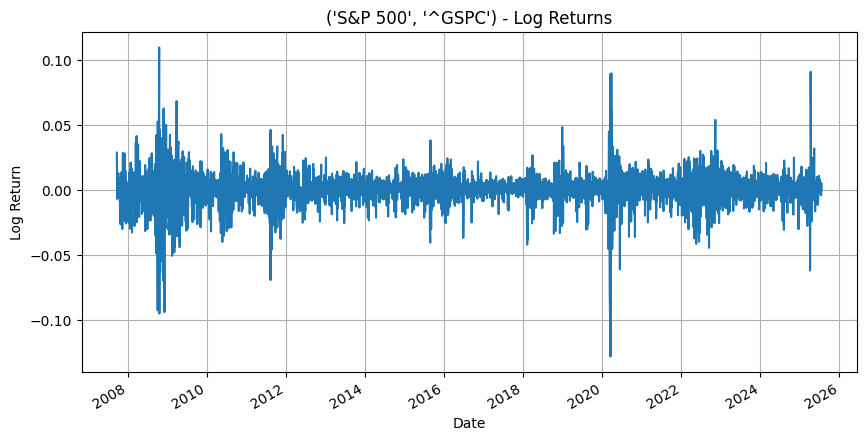

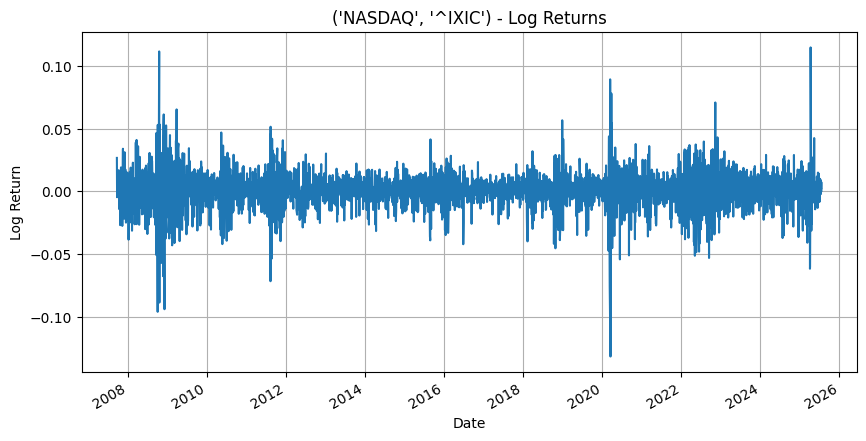

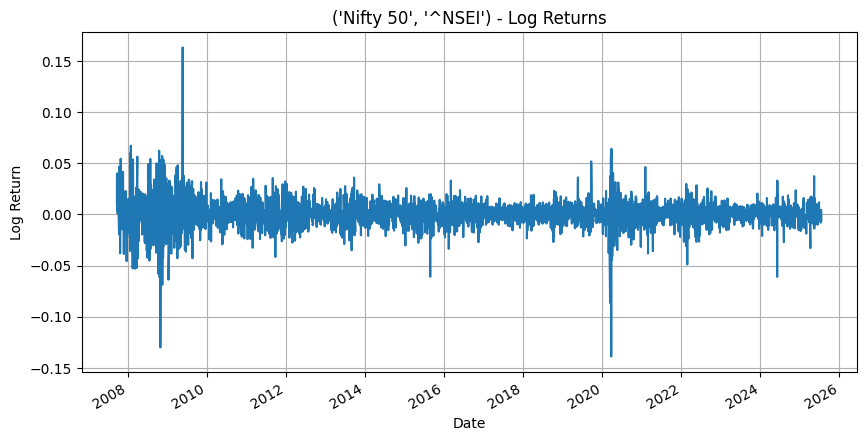

In [304]:
for column in log_returns.columns:
    plt.figure(figsize=(10, 5))
    log_returns[column].dropna().plot(title=f"{column} - Log Returns")
    plt.ylabel("Log Return")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

<Figure size 800x400 with 0 Axes>

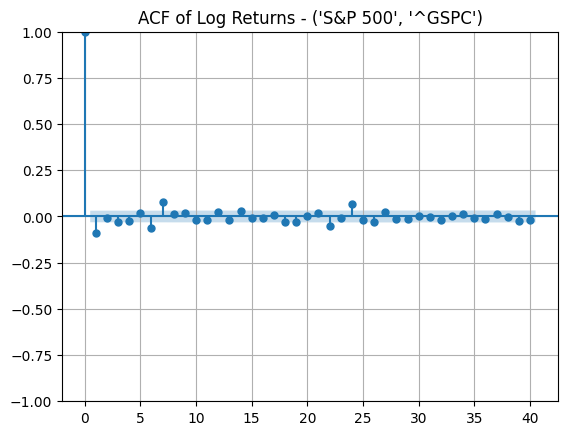

<Figure size 800x400 with 0 Axes>

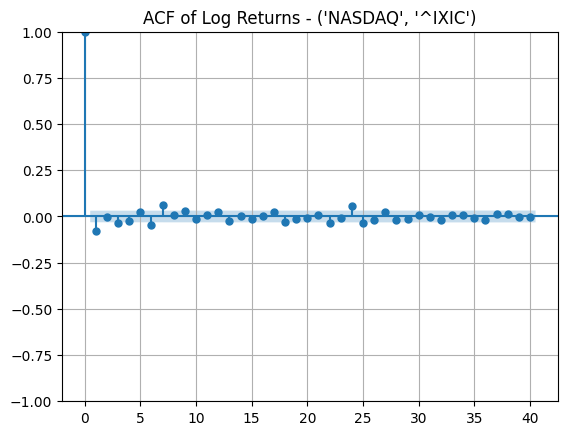

<Figure size 800x400 with 0 Axes>

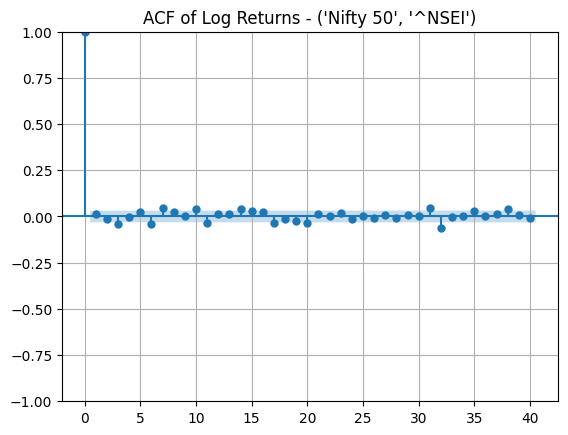

In [305]:
for column in log_returns.columns:
    plt.figure(figsize=(8, 4))
    plot_acf(log_returns[column], lags=40, title=f"ACF of Log Returns - {column}")
    plt.grid(True)
    plt.show()

<Figure size 800x400 with 0 Axes>

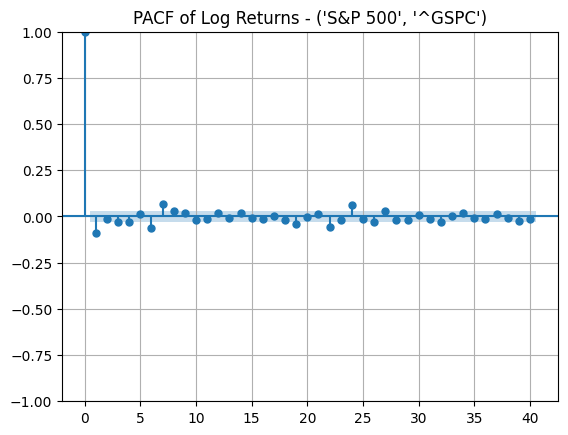

<Figure size 800x400 with 0 Axes>

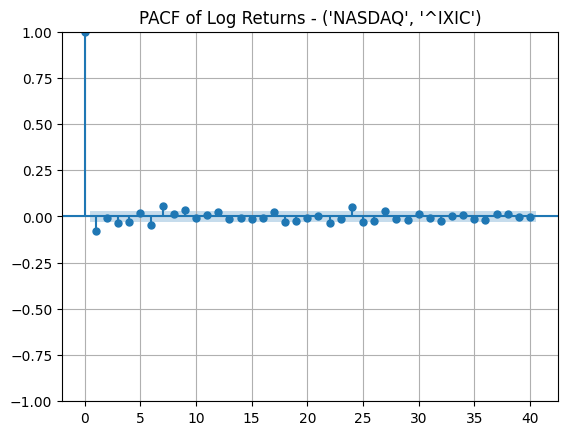

<Figure size 800x400 with 0 Axes>

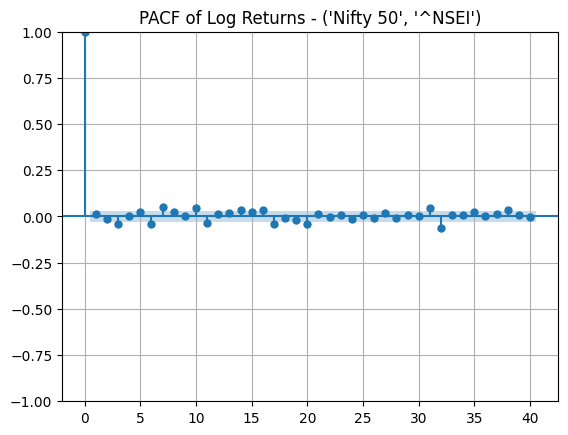

In [306]:
for column in log_returns.columns:
    plt.figure(figsize=(8, 4))
    plot_pacf(log_returns[column], lags=40, title=f"PACF of Log Returns - {column}")
    plt.grid(True)
    plt.show()

In [307]:
for column in log_returns.columns:
    print(f"Stationarity Tests for {column}:")
    
    adf_result = adfuller(log_returns[column])
    print("  ADF Test Statistic:", adf_result[0])
    print("  ADF p-value:", adf_result[1])

    kpss_result = kpss(log_returns[column], regression='c', nlags='auto')
    print("  KPSS Test Statistic:", kpss_result[0])
    print("  KPSS p-value:", kpss_result[1])

Stationarity Tests for ('S&P 500', '^GSPC'):
  ADF Test Statistic: -12.511305718490355
  ADF p-value: 2.670550457801739e-23
  KPSS Test Statistic: 0.4014783139336528
  KPSS p-value: 0.07651796813204621
Stationarity Tests for ('NASDAQ', '^IXIC'):
  ADF Test Statistic: -12.41509842727306
  ADF p-value: 4.258013628383649e-23
  KPSS Test Statistic: 0.328950455039628
  KPSS p-value: 0.1
Stationarity Tests for ('Nifty 50', '^NSEI'):
  ADF Test Statistic: -11.153662973565234
  ADF p-value: 2.901614344818297e-20
  KPSS Test Statistic: 0.10218227588475602
  KPSS p-value: 0.1


/var/folders/fn/z7ws07_d7wxbd0srcdtdkt6m0000gp/T/ipykernel_87402/3521174186.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(log_returns[column], regression='c', nlags='auto')
/var/folders/fn/z7ws07_d7wxbd0srcdtdkt6m0000gp/T/ipykernel_87402/3521174186.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(log_returns[column], regression='c', nlags='auto')


In [308]:
def select_best_arima(series, p_range=(0, 3), d_range=(0, 1), q_range=(0, 3)):
    best_aic = float('inf')
    best_order = None
    best_model = None

    for p in range(*p_range):
        for d in range(*d_range):
            for q in range(*q_range):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    result = model.fit()
                    if result.aic < best_aic:
                        best_aic = result.aic
                        best_order = (p, d, q)
                        best_model = result
                except Exception:
                    continue
    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    return best_model, best_order

Fitting ARIMA model for ('S&P 500', '^GSPC')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -23165.517362655046
                                SARIMAX Results                                 
Dep. Variable:     ('S&P 500', '^GSPC')   No. Observations:                 3922
Model:                   ARIMA(0, 0, 1)   Log Likelihood               11585.759
Date:                  Fri, 08 Aug 2025   AIC                         -23165.517
Time:                          00:04:58   BIC                         -23146.694
Sample:                               0   HQIC                        -23158.838
                                 - 3922                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.489      0.136   -9.04e-05       0.001
ma.L1         -0.0895      0.007    -12.702      0.000   

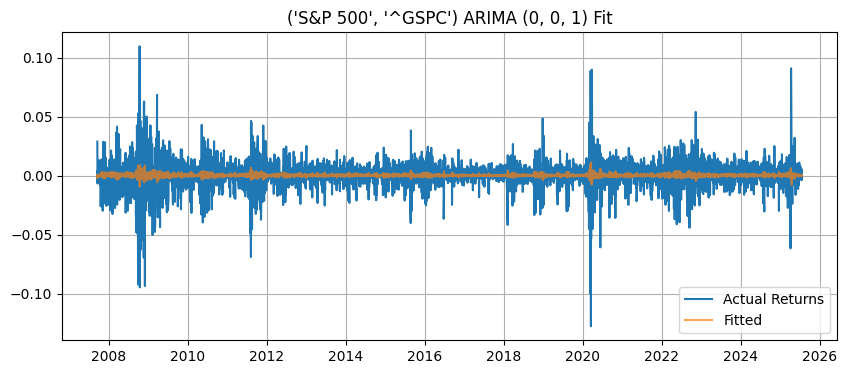

Fitting ARIMA model for ('NASDAQ', '^IXIC')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -22190.060929800704
                                SARIMAX Results                                
Dep. Variable:     ('NASDAQ', '^IXIC')   No. Observations:                 3922
Model:                  ARIMA(0, 0, 1)   Log Likelihood               11098.030
Date:                 Fri, 08 Aug 2025   AIC                         -22190.061
Time:                         00:05:00   BIC                         -22171.238
Sample:                              0   HQIC                        -22183.382
                                - 3922                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.996      0.046    7.82e-06       0.001
ma.L1         -0.0778      0.008     -9.237      0.000      -0.09

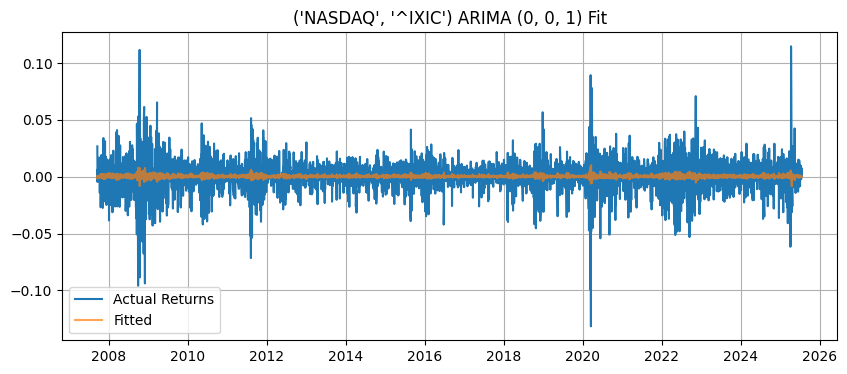

Fitting ARIMA model for ('Nifty 50', '^NSEI')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 0) with AIC: -22966.309486912236
                                 SARIMAX Results                                 
Dep. Variable:     ('Nifty 50', '^NSEI')   No. Observations:                 3922
Model:                             ARIMA   Log Likelihood               11485.155
Date:                   Fri, 08 Aug 2025   AIC                         -22966.309
Time:                           00:05:04   BIC                         -22953.761
Sample:                                0   HQIC                        -22961.857
                                  - 3922                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.604      0.109   -7.37e-05       0.001
sigma2         0.0002   1.26e-06    132.867      

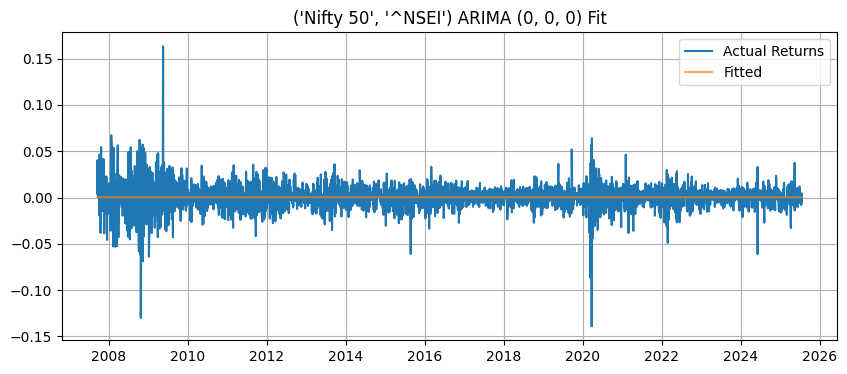

In [309]:
for column in log_returns.columns:
    print(f"Fitting ARIMA model for {column}")
    series = log_returns[column].dropna()

    try:
        arima_result, best_arima_order = select_best_arima(series)
        print(arima_result.summary())

        plt.figure(figsize=(10, 4))
        plt.plot(series, label="Actual Returns")
        plt.plot(arima_result.fittedvalues, label="Fitted", alpha=0.7)
        plt.title(f"{column} ARIMA {best_arima_order} Fit")
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"ARIMA model failed for {column}: {e}")

In [310]:
def select_best_garch(residuals, vol_type='GARCH', p_range=(1, 3), q_range=(1, 3), o_value=0):
    from arch import arch_model
    best_aic = float('inf')
    best_model = None
    best_order = None

    for p in range(*p_range):
        for q in range(*q_range):
            try:
                model = arch_model(residuals * 100, vol=vol_type, p=p, o=o_value, q=q)
                result = model.fit(disp='off')
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, o_value, q)
                    best_model = result
            except:
                continue
    print(f"Best {vol_type} order: {best_order} with AIC: {best_aic}")
    return best_model, best_order


Fitting GARCH model to ARIMA residuals for ('S&P 500', '^GSPC')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -23165.517362655046


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

Best GARCH order: (2, 0, 1) with AIC: 46968.00914902272
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -23479.0
Distribution:                  Normal   AIC:                           46968.0
Method:            Maximum Likelihood   BIC:                           46999.4
                                        No. Observations:                 3922
Date:                Fri, Aug 08 2025   Df Residuals:                     3921
Time:                        00:05:07   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


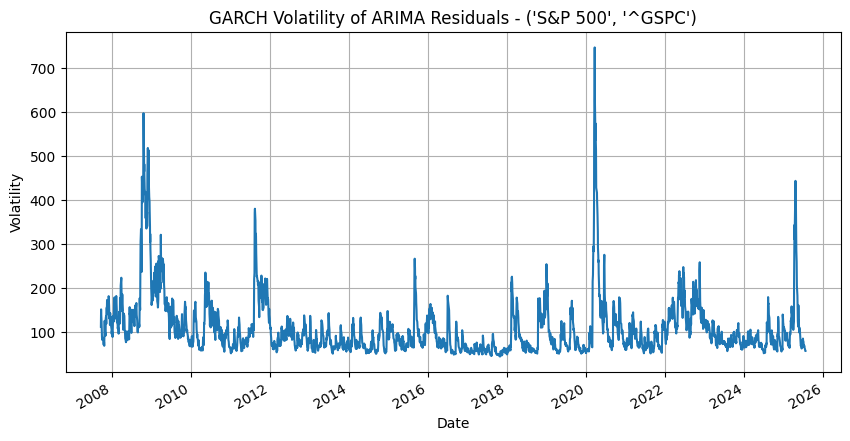

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Fitting GARCH model to ARIMA residuals for ('NASDAQ', '^IXIC')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -22190.060929800704


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may a

Best GARCH order: (2, 0, 1) with AIC: 48497.014043751784
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -24243.5
Distribution:                  Normal   AIC:                           48497.0
Method:            Maximum Likelihood   BIC:                           48528.4
                                        No. Observations:                 3922
Date:                Fri, Aug 08 2025   Df Residuals:                     3921
Time:                        00:05:10   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu           

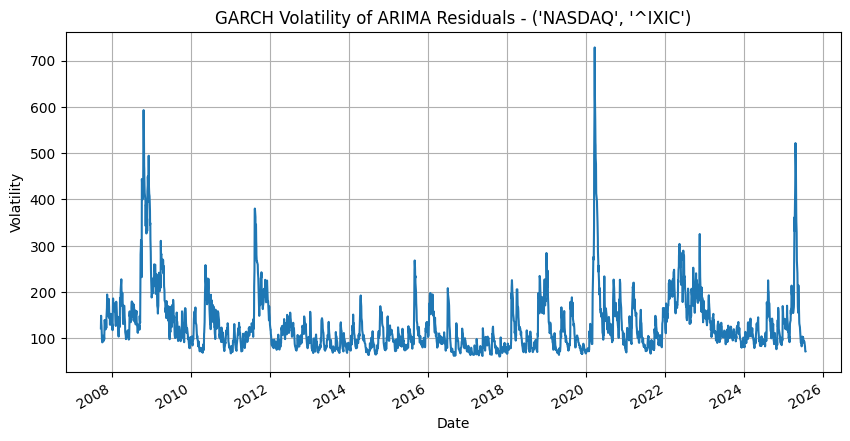

Fitting GARCH model to ARIMA residuals for ('Nifty 50', '^NSEI')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 0) with AIC: -22966.309486912236


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best GARCH order: (1, 0, 1) with AIC: 47584.33565019365
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -23788.2
Distribution:                  Normal   AIC:                           47584.3
Method:            Maximum Likelihood   BIC:                           47609.4
                                        No. Observations:                 3922
Date:                Fri, Aug 08 2025   Df Residuals:                     3921
Time:                        00:05:13   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu   

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

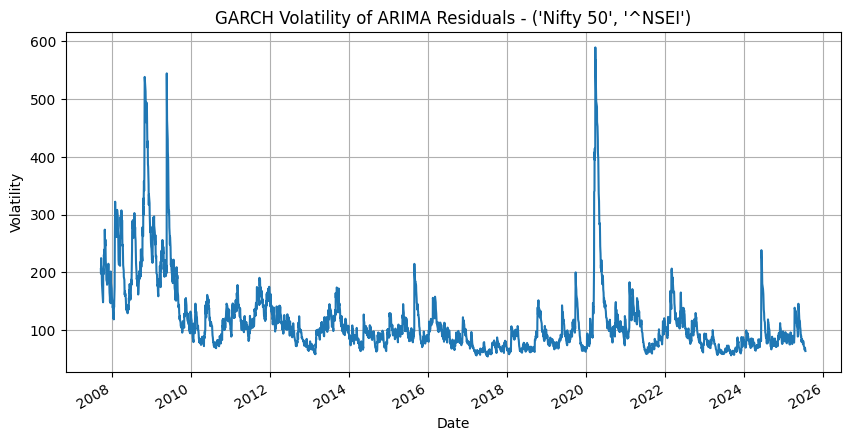

In [311]:
for index_name in log_returns.columns:
    print(f"Fitting GARCH model to ARIMA residuals for {index_name}..")
    
    series = log_returns[index_name].dropna()
    arima_result = ARIMA(series, order= select_best_arima(series)[1]).fit()
    residuals = arima_result.resid.dropna()
    innovations = residuals * 100
    
    results, best_garch_order = select_best_garch(innovations)

    print(results.summary())
    
    volatility = results.conditional_volatility
    
    plt.figure(figsize=(10, 5))
    volatility.plot(title=f"GARCH Volatility of ARIMA Residuals - {index_name}")
    plt.ylabel("Volatility")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Fitting EGARCH model to ARIMA residuals for ('S&P 500', '^GSPC')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

Best ARIMA order: (0, 0, 1) with AIC: -23165.517362655046


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

Best EGARCH order: (2, 0, 2) with AIC: 46984.717314039946
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -23486.4
Distribution:                  Normal   AIC:                           46984.7
Method:            Maximum Likelihood   BIC:                           47022.4
                                        No. Observations:                 3922
Date:                Fri, Aug 08 2025   Df Residuals:                     3921
Time:                        00:05:16   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu          

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


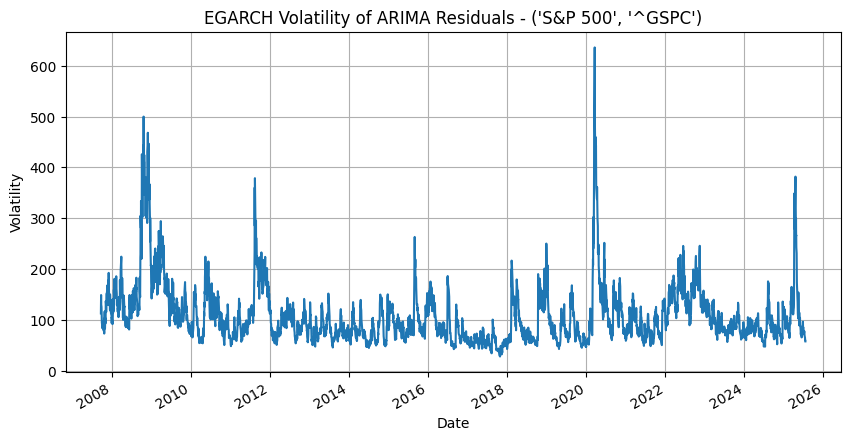

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Fitting EGARCH model to ARIMA residuals for ('NASDAQ', '^IXIC')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -22190.060929800704


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may a

Best EGARCH order: (2, 0, 2) with AIC: 48519.00865765124
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -24253.5
Distribution:                  Normal   AIC:                           48519.0
Method:            Maximum Likelihood   BIC:                           48556.7
                                        No. Observations:                 3922
Date:                Fri, Aug 08 2025   Df Residuals:                     3921
Time:                        00:05:19   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu           

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.04e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


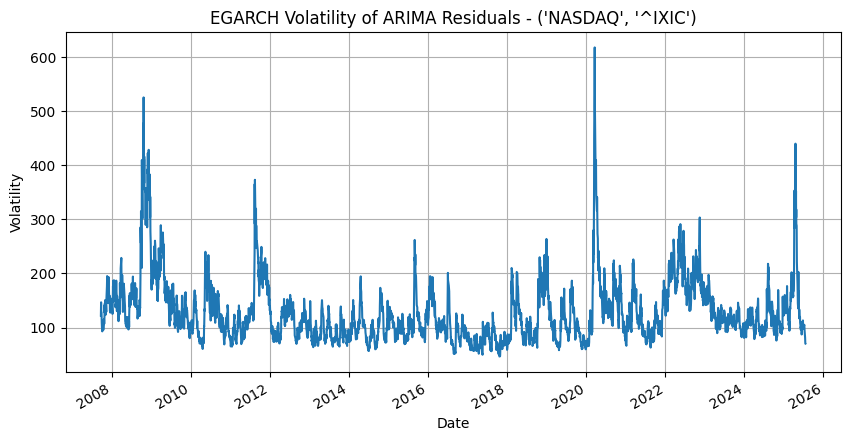

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Fitting EGARCH model to ARIMA residuals for ('Nifty 50', '^NSEI')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

Best ARIMA order: (0, 0, 0) with AIC: -22966.309486912236


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may a

Best EGARCH order: (2, 0, 2) with AIC: 47595.38398831971
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -23791.7
Distribution:                  Normal   AIC:                           47595.4
Method:            Maximum Likelihood   BIC:                           47633.0
                                        No. Observations:                 3922
Date:                Fri, Aug 08 2025   Df Residuals:                     3921
Time:                        00:05:23   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu           

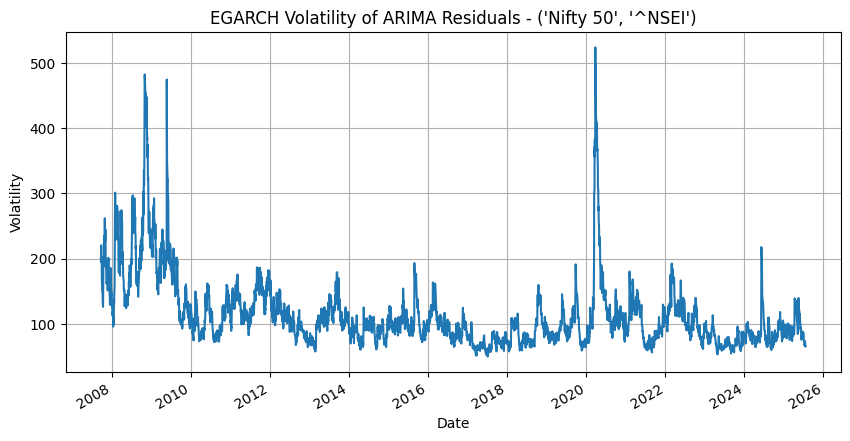

In [312]:
for index_name in log_returns.columns:
    print(f"Fitting EGARCH model to ARIMA residuals for {index_name}..")
    
    series = log_returns[index_name].dropna()
    arima_result = ARIMA(series, order= select_best_arima(series)[1]).fit()
    residuals = arima_result.resid.dropna()
    innovations = residuals * 100

    results_egarch, order = select_best_garch(innovations, vol_type='EGARCH', o_value=0)
    
    print(results_egarch.summary())

    plt.figure(figsize=(10, 5))
    results_egarch.conditional_volatility.plot(title= f"EGARCH Volatility of ARIMA Residuals - {index_name}")
    plt.ylabel("Volatility")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

Fitting GJR-GARCH model to ARIMA residuals for ('S&P 500', '^GSPC')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -23165.517362655046


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

Best GARCH order: (1, 1, 1) with AIC: 46859.41490055733
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -23424.7
Distribution:                  Normal   AIC:                           46859.4
Method:            Maximum Likelihood   BIC:                           46890.8
                                        No. Observations:                 3922
Date:                Fri, Aug 08 2025   Df Residuals:                     3921
Time:                        00:05:26   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


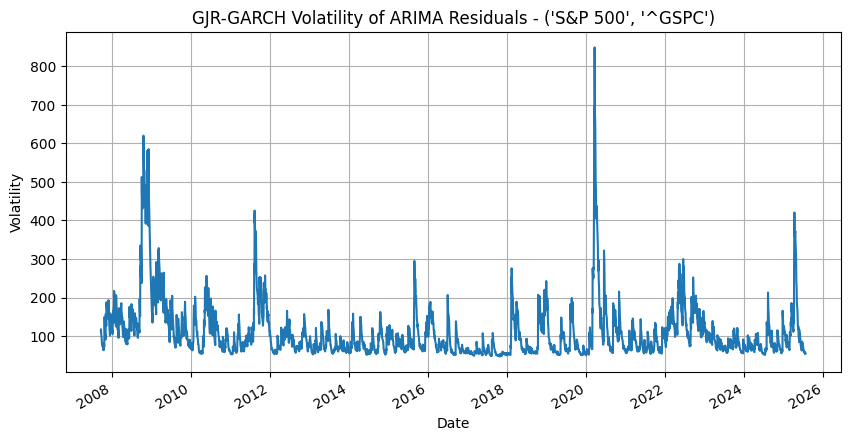

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Fitting GJR-GARCH model to ARIMA residuals for ('NASDAQ', '^IXIC')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -22190.060929800704


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may a

Best GARCH order: (2, 1, 1) with AIC: 48394.231703459795
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -24191.1
Distribution:                  Normal   AIC:                           48394.2
Method:            Maximum Likelihood   BIC:                           48431.9
                                        No. Observations:                 3922
Date:                Fri, Aug 08 2025   Df Residuals:                     3921
Time:                        00:05:28   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu           

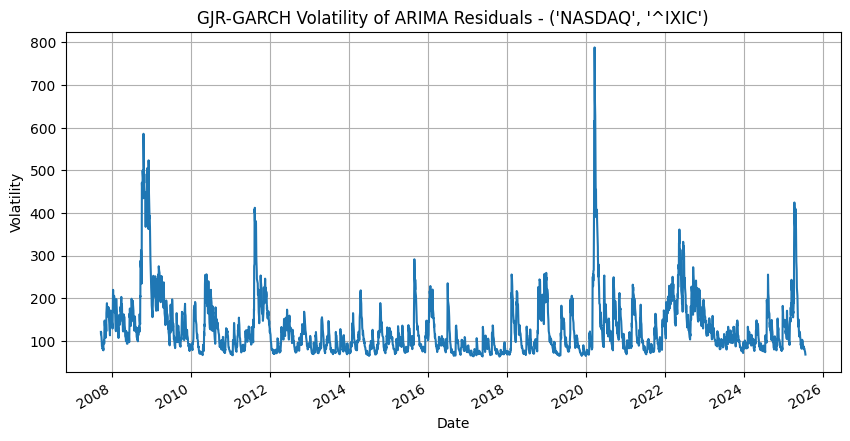

Fitting GJR-GARCH model to ARIMA residuals for ('Nifty 50', '^NSEI')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 0) with AIC: -22966.309486912236


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best GARCH order: (1, 1, 1) with AIC: 47518.23810127875
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -23754.1
Distribution:                  Normal   AIC:                           47518.2
Method:            Maximum Likelihood   BIC:                           47549.6
                                        No. Observations:                 3922
Date:                Fri, Aug 08 2025   Df Residuals:                     3921
Time:                        00:05:32   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

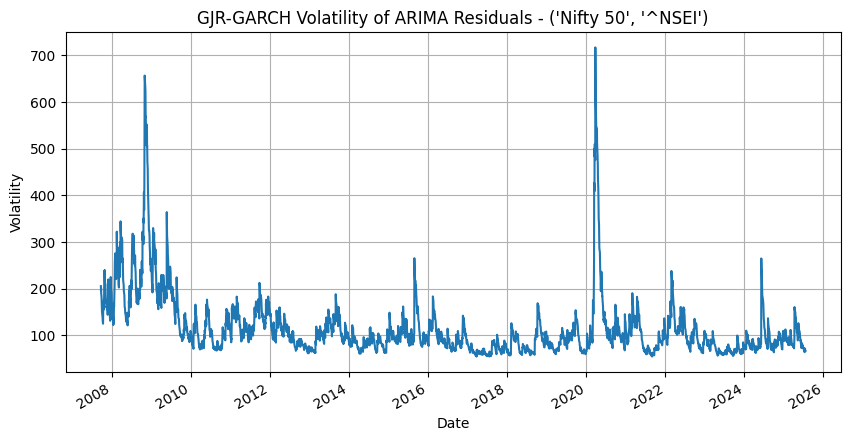

In [313]:
for index_name in log_returns.columns:
    print(f"Fitting GJR-GARCH model to ARIMA residuals for {index_name}..")

    series = log_returns[index_name].dropna()
    arima_result = ARIMA(series, order= select_best_arima(series)[1]).fit()
    residuals = arima_result.resid.dropna()
    innovations = residuals * 100
    
    results_gjr, order = select_best_garch(innovations, vol_type='GARCH', o_value=1)
    
    print(results_gjr.summary())

    plt.figure(figsize=(10, 5))
    results_gjr.conditional_volatility.plot(title=f"GJR-GARCH Volatility of ARIMA Residuals - {index_name}")
    plt.ylabel("Volatility")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Fitting Markov Switching Model to ARIMA residuals for ('S&P 500', '^GSPC')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

Best ARIMA order: (0, 0, 1) with AIC: -23165.517362655046


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

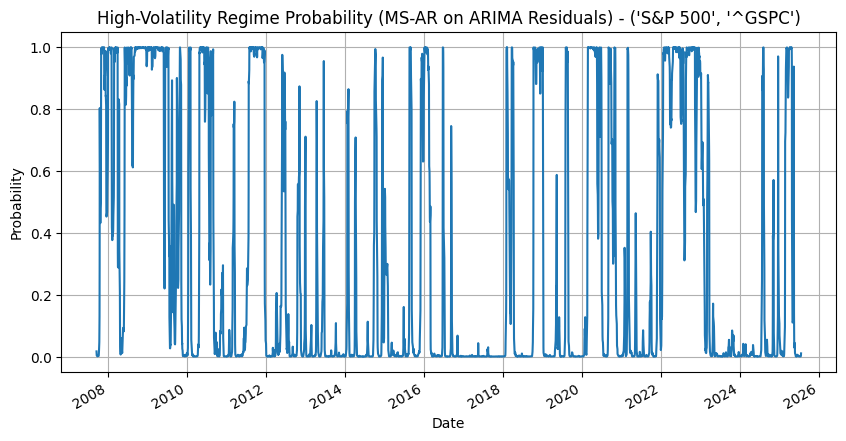

Fitting Markov Switching Model to ARIMA residuals for ('NASDAQ', '^IXIC')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -22190.060929800704


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

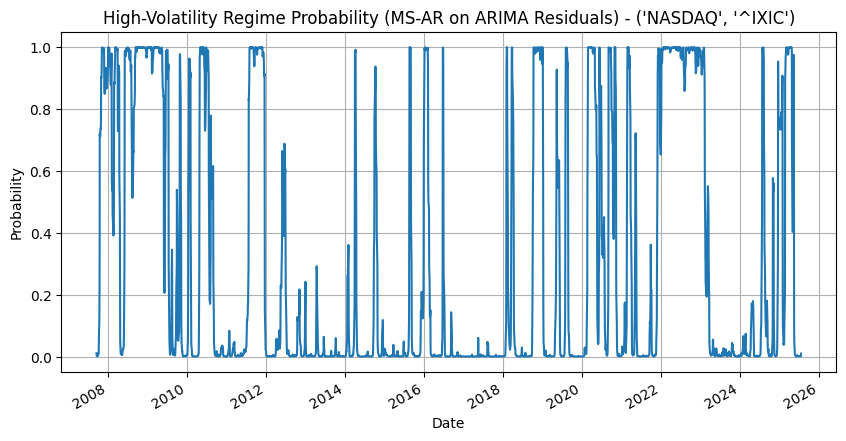

Fitting Markov Switching Model to ARIMA residuals for ('Nifty 50', '^NSEI')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 0) with AIC: -22966.309486912236


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

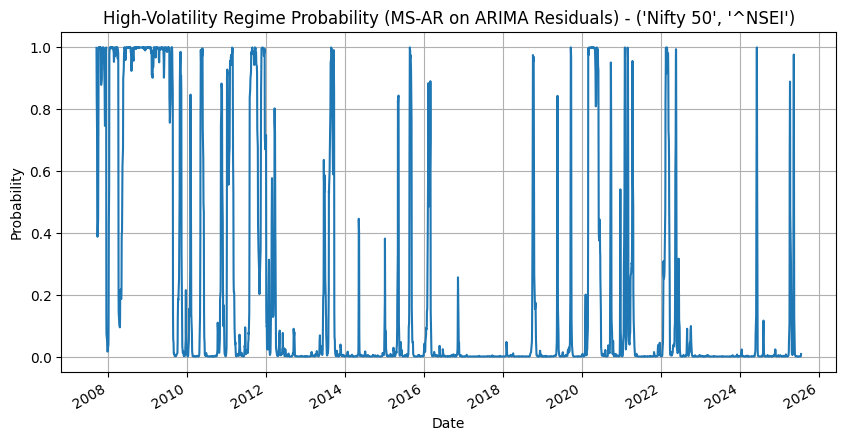

In [314]:
for index_name in log_returns.columns:
    print(f"Fitting Markov Switching Model to ARIMA residuals for {index_name}..")
    
    series = log_returns[index_name].dropna()
    arima_result = ARIMA(series, order= select_best_arima(series)[1]).fit()
    residuals = arima_result.resid.dropna()
    innovations = residuals * 100
    
    ms_model = MarkovAutoregression(innovations, k_regimes=2, order=1, trend='c', switching_variance=True)
    ms_results = ms_model.fit(disp=False)
    
    regime_prob = ms_results.smoothed_marginal_probabilities[1]

    plt.figure(figsize=(10, 5))
    regime_prob.plot(title=f"High-Volatility Regime Probability (MS-AR on ARIMA Residuals) - {index_name}")
    plt.ylabel("Probability")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

Fitting Markov Switching Model for ('S&P 500', '^GSPC')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


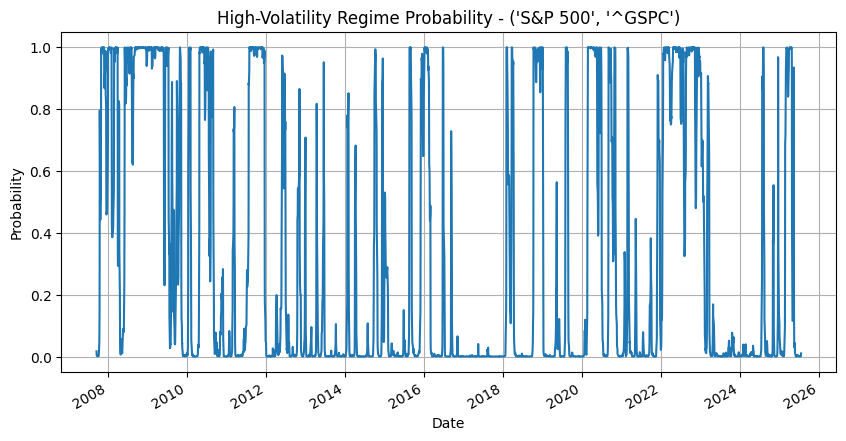

Fitting Markov Switching Model for ('NASDAQ', '^IXIC')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


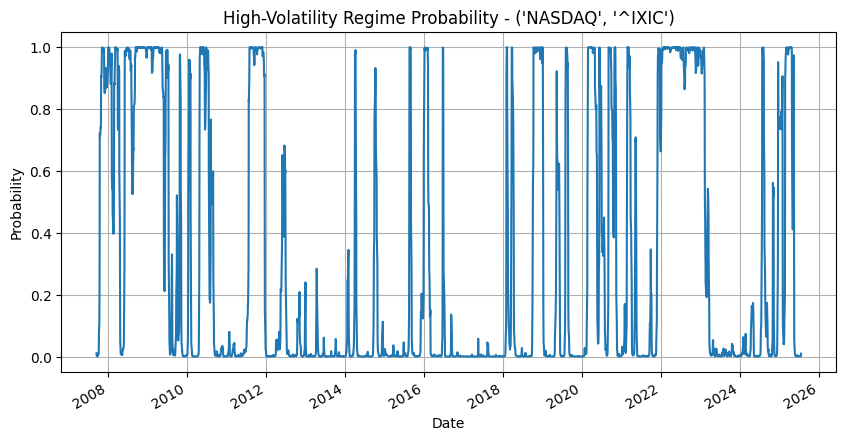

Fitting Markov Switching Model for ('Nifty 50', '^NSEI')..


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


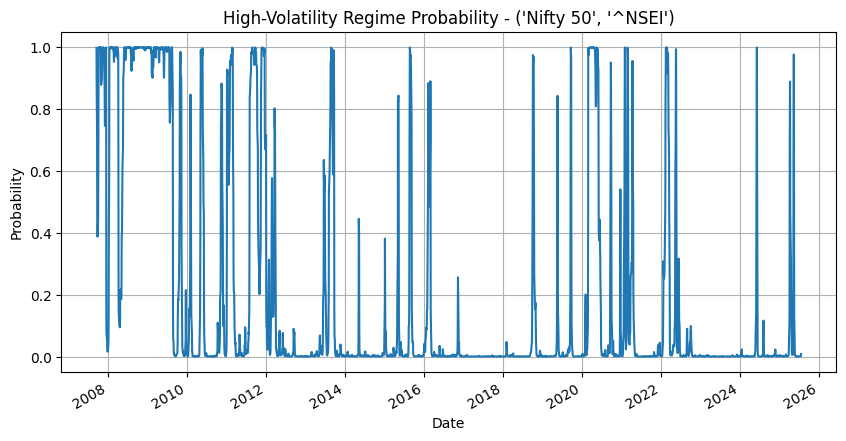

In [315]:
for index_name in log_returns.columns:
    print(f"Fitting Markov Switching Model for {index_name}..")
    
    series = log_returns[index_name].dropna()
    
    ms_model = MarkovAutoregression(series, k_regimes=2, order=1, trend='c', switching_variance=True)
    ms_results = ms_model.fit(disp=False)
    
    regime_prob = ms_results.smoothed_marginal_probabilities[1]

    plt.figure(figsize=(10, 5))
    regime_prob.plot(title=f"High-Volatility Regime Probability - {index_name}")
    plt.ylabel("Probability")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()


In [316]:
def qlike(true, forecast):
    forecast = np.array(forecast)
    true = np.array(true)
    return np.mean(np.log(forecast**2) + (true**2) / forecast**2)

Rolling Forecast Comparison for ('S&P 500', '^GSPC')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -23165.517362655046
Best GARCH order: (2, 0, 1) with AIC: 37442.36340983915


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.636e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.636e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

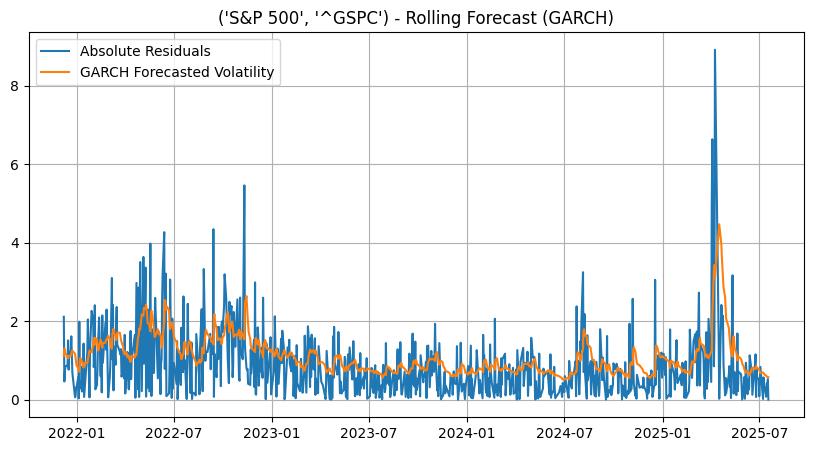

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.636e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.636e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best EGARCH order: (2, 0, 2) with AIC: 37457.82074768008


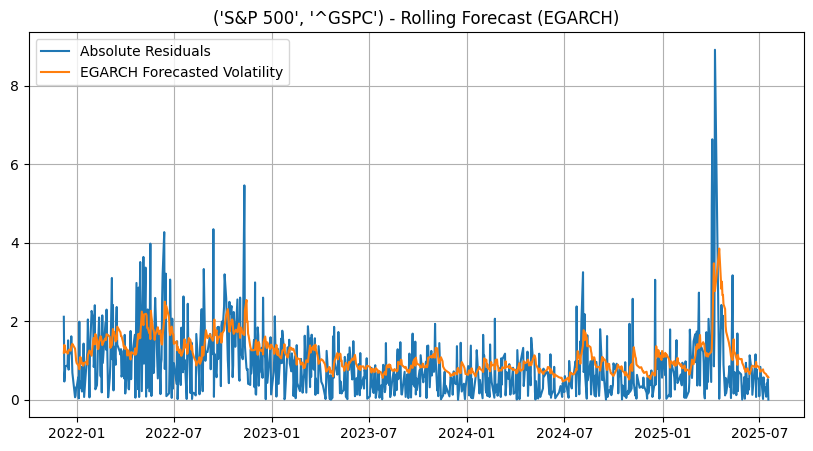

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.636e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.636e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best GARCH order: (1, 1, 1) with AIC: 37361.443929730856


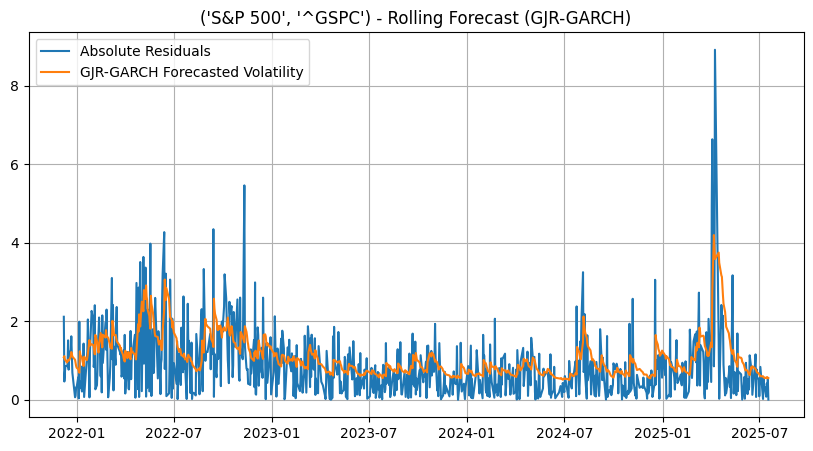

Rolling Forecast Comparison for ('NASDAQ', '^IXIC')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -22190.060929800704
Best GARCH order: (2, 0, 1) with AIC: 38489.901166237396


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.933e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.933e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

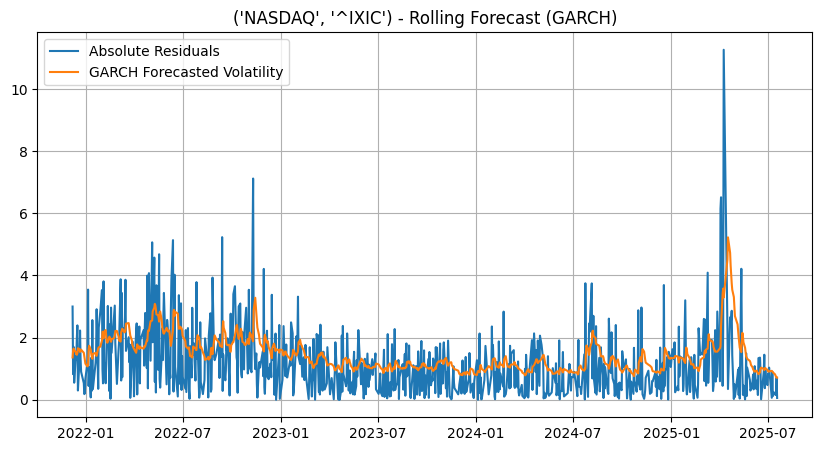

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.933e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.933e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best EGARCH order: (2, 0, 2) with AIC: 38516.062435273554


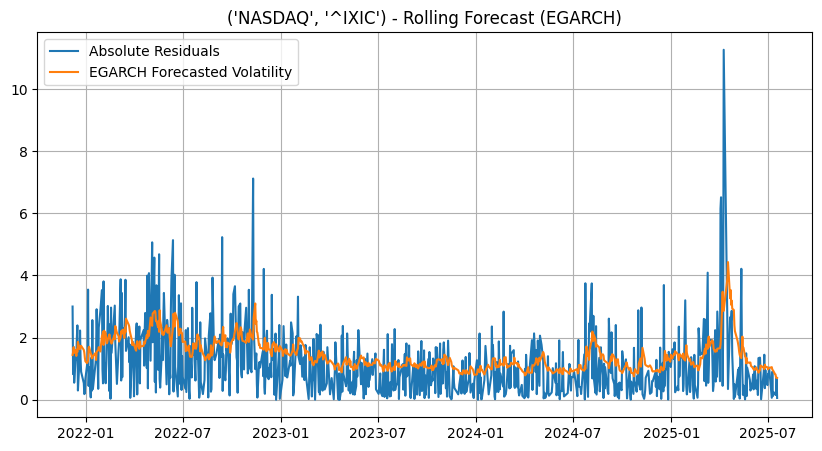

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.933e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.933e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best GARCH order: (2, 1, 1) with AIC: 38403.79787743058


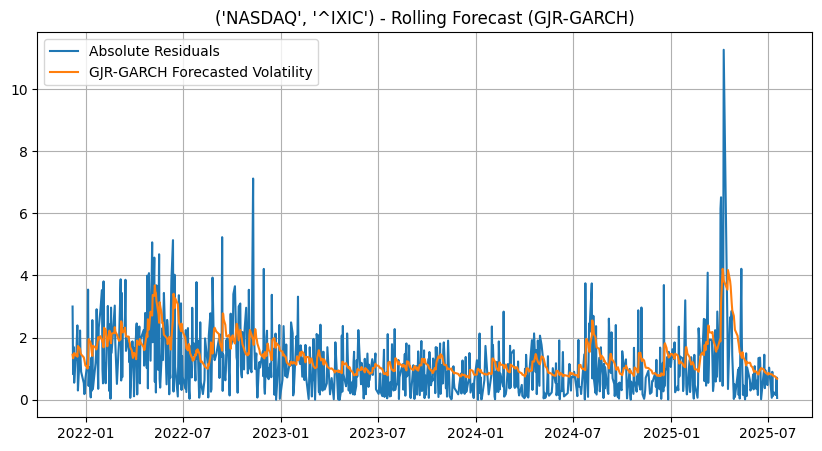

Rolling Forecast Comparison for ('Nifty 50', '^NSEI')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 0) with AIC: -22966.309486912236
Best GARCH order: (1, 0, 1) with AIC: 38396.66553219054


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.895e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.895e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

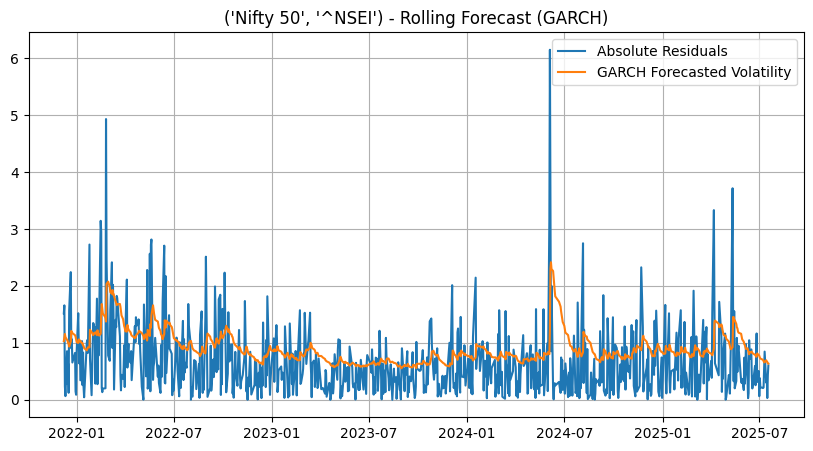

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.895e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.895e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best EGARCH order: (2, 0, 2) with AIC: 38411.03350973627


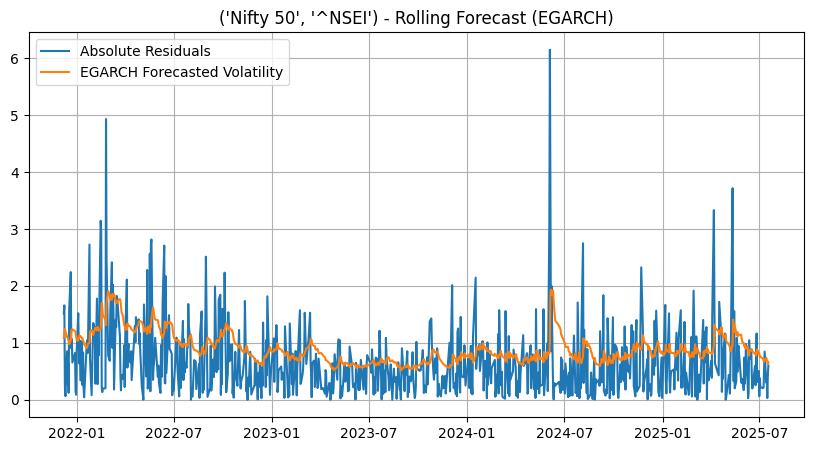

/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.895e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.895e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best GARCH order: (2, 1, 1) with AIC: 38319.61334104263


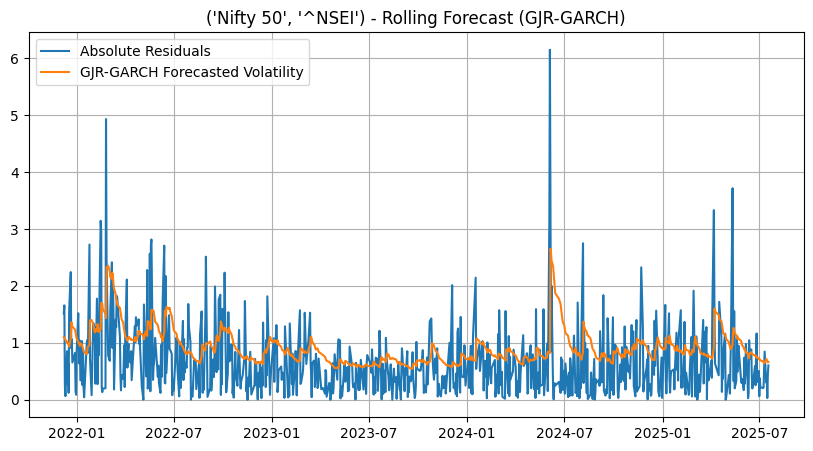

Forecast Performance Summary:
+-----------------------+-----------+----------+----------+-----------------------+
| Index                 | Model     |      MSE |    QLIKE |   VaR Exceedance Rate |
+=======================+===========+==========+==========+=======================+
| ('S&P 500', '^GSPC')  | GARCH     | 0.723733 | 1.08927  |             0.0598726 |
+-----------------------+-----------+----------+----------+-----------------------+
| ('S&P 500', '^GSPC')  | EGARCH    | 0.70692  | 1.08994  |             0.0585987 |
+-----------------------+-----------+----------+----------+-----------------------+
| ('S&P 500', '^GSPC')  | GJR-GARCH | 0.685837 | 1.05384  |             0.0649682 |
+-----------------------+-----------+----------+----------+-----------------------+
| ('NASDAQ', '^IXIC')   | GARCH     | 1.17128  | 1.70331  |             0.0636943 |
+-----------------------+-----------+----------+----------+-----------------------+
| ('NASDAQ', '^IXIC')   | EGARCH    | 1.13541 

In [317]:
forecast_results = []

for index_name in log_returns.columns:
    print(f"Rolling Forecast Comparison for {index_name}")
    
    series = log_returns[index_name].dropna()
    arima_result, _ = select_best_arima(series)
    residuals = arima_result.resid.dropna()
    innovations = residuals * 100

    train_size = int(0.8 * len(innovations))
    train, test = innovations[:train_size], innovations[train_size:]
    test_index = test.index

    model_types = {
        "GARCH": {"vol": "GARCH", "o_value": 0},
        "EGARCH": {"vol": "EGARCH", "o_value": 0},
        "GJR-GARCH": {"vol": "GARCH", "o_value": 1}
    }

    for model_name, params in model_types.items():
        try:
            garch_result, best_order = select_best_garch(train, vol_type=params["vol"], o_value=params["o_value"])
            p, _, q = best_order

            rolling_predictions = []
            for i in range(len(test)):
                history = pd.concat([train, test.iloc[:i]]).copy()
                model = arch_model(history, vol=params["vol"], p=p, o=params["o_value"], q=q)
                res = model.fit(disp='off')
                forecast = res.forecast(horizon=1)
                pred_vol = forecast.variance.iloc[-1, 0]**0.5
                rolling_predictions.append(pred_vol)

            predicted_vol = np.array(rolling_predictions)
            abs_residuals = np.abs(test.values)

            mse = mean_squared_error(abs_residuals, predicted_vol)
            qlike_loss = qlike(test.values, predicted_vol)
            var_level = 0.05
            VaR = norm.ppf(var_level) * predicted_vol
            exceedances = test < VaR
            exceedance_rate = np.mean(exceedances)

            forecast_results.append({
                "Index": index_name,
                "Model": model_name,
                "MSE": mse,
                "QLIKE": qlike_loss,
                "VaR Exceedance Rate": exceedance_rate
            })

            plt.figure(figsize=(10, 5))
            plt.plot(test_index, abs_residuals, label="Absolute Residuals")
            plt.plot(test_index, predicted_vol, label=f"{model_name} Forecasted Volatility")
            plt.legend()
            plt.title(f"{index_name} - Rolling Forecast ({model_name})")
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"{model_name} forecast failed for {index_name}: {e}")

results_df = pd.DataFrame(forecast_results)
print("Forecast Performance Summary:")
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))


Global Financial Crisis (2008-2009) - ('S&P 500', '^GSPC')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -23165.517362655046
Best GARCH order: (2, 0, 1) with AIC: 46968.00914902272


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best EGARCH order: (2, 0, 2) with AIC: 46984.717314039946
Best GARCH order: (1, 1, 1) with AIC: 46859.41490055733


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

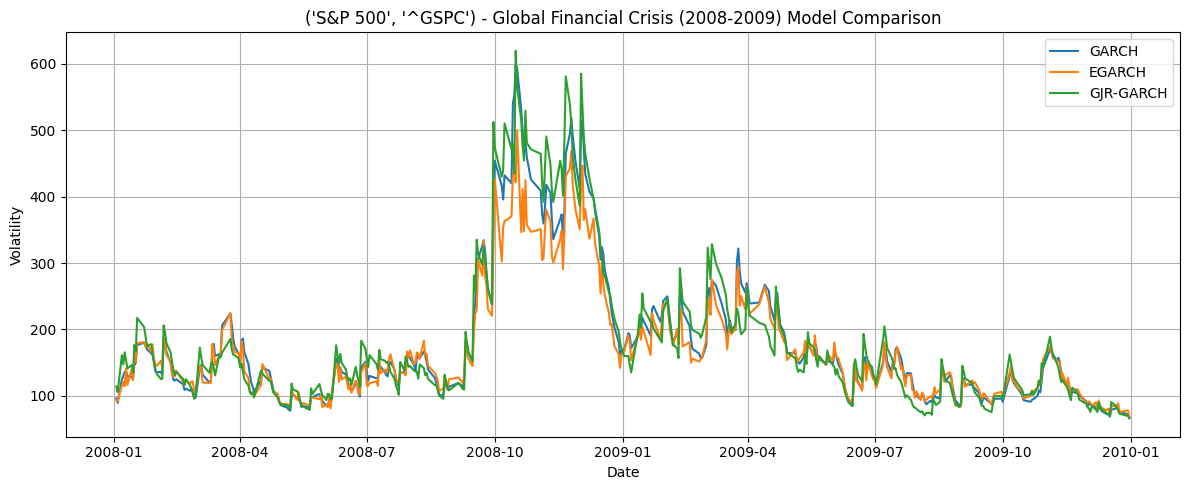

Global Financial Crisis (2008-2009) - ('NASDAQ', '^IXIC')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -22190.060929800704
Best GARCH order: (2, 0, 1) with AIC: 48497.014043751784


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.04e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.04e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohan

Best EGARCH order: (2, 0, 2) with AIC: 48519.00865765124
Best GARCH order: (2, 1, 1) with AIC: 48394.231703459795


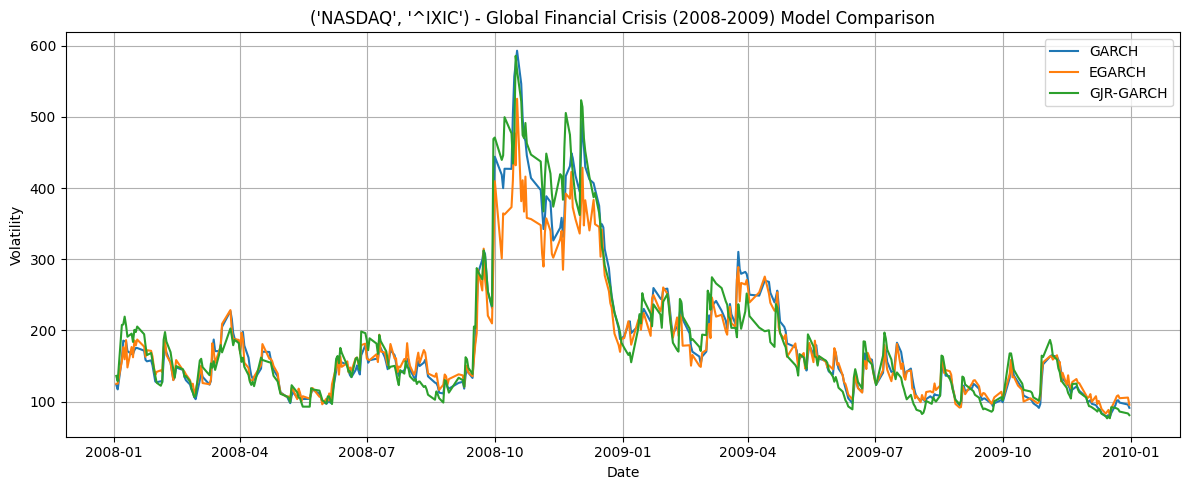

Global Financial Crisis (2008-2009) - ('Nifty 50', '^NSEI')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 0) with AIC: -22966.309486912236
Best GARCH order: (1, 0, 1) with AIC: 47584.33565019365


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best EGARCH order: (2, 0, 2) with AIC: 47595.38398831971
Best GARCH order: (1, 1, 1) with AIC: 47518.23810127875


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

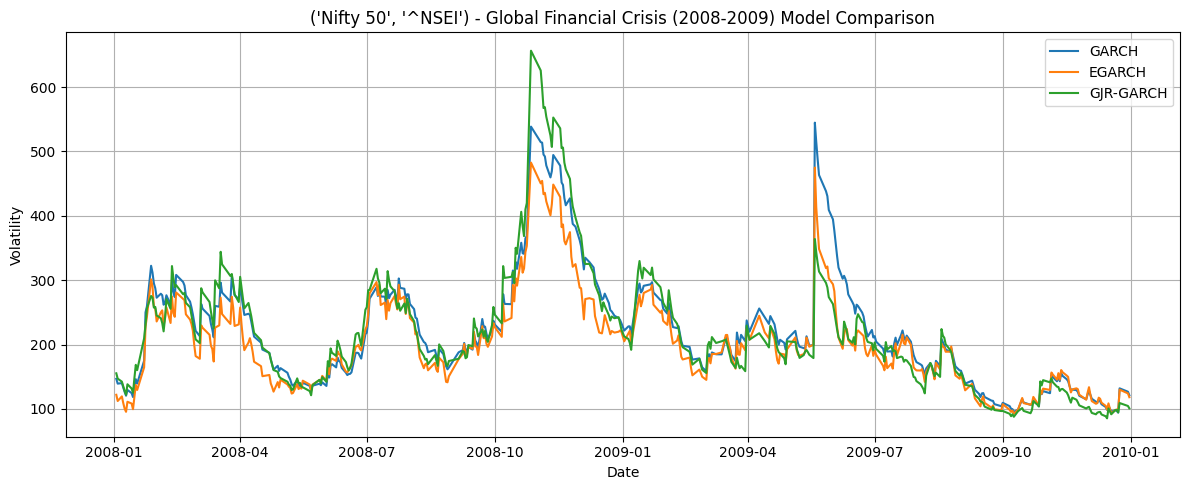

COVID-19 Crash (2020) - ('S&P 500', '^GSPC')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -23165.517362655046
Best GARCH order: (2, 0, 1) with AIC: 46968.00914902272


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best EGARCH order: (2, 0, 2) with AIC: 46984.717314039946
Best GARCH order: (1, 1, 1) with AIC: 46859.41490055733


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

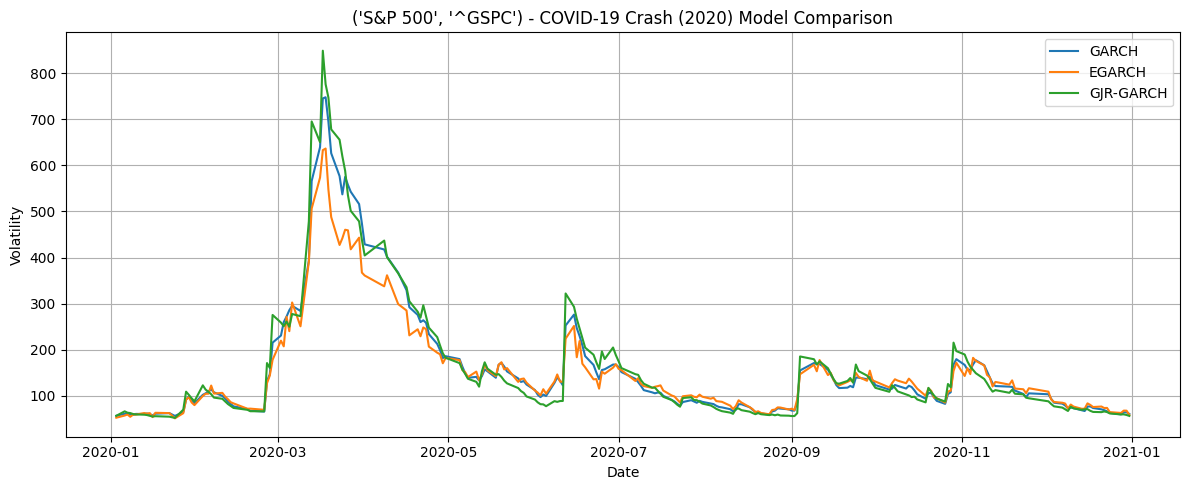

COVID-19 Crash (2020) - ('NASDAQ', '^IXIC')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -22190.060929800704
Best GARCH order: (2, 0, 1) with AIC: 48497.014043751784


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.04e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.04e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohan

Best EGARCH order: (2, 0, 2) with AIC: 48519.00865765124
Best GARCH order: (2, 1, 1) with AIC: 48394.231703459795


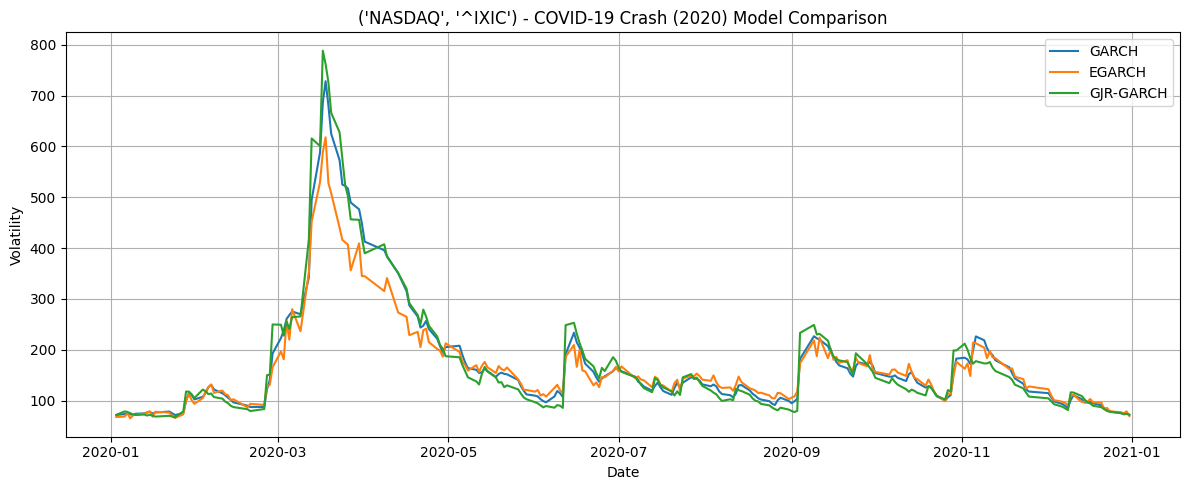

COVID-19 Crash (2020) - ('Nifty 50', '^NSEI')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 0) with AIC: -22966.309486912236
Best GARCH order: (1, 0, 1) with AIC: 47584.33565019365


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best EGARCH order: (2, 0, 2) with AIC: 47595.38398831971
Best GARCH order: (1, 1, 1) with AIC: 47518.23810127875


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

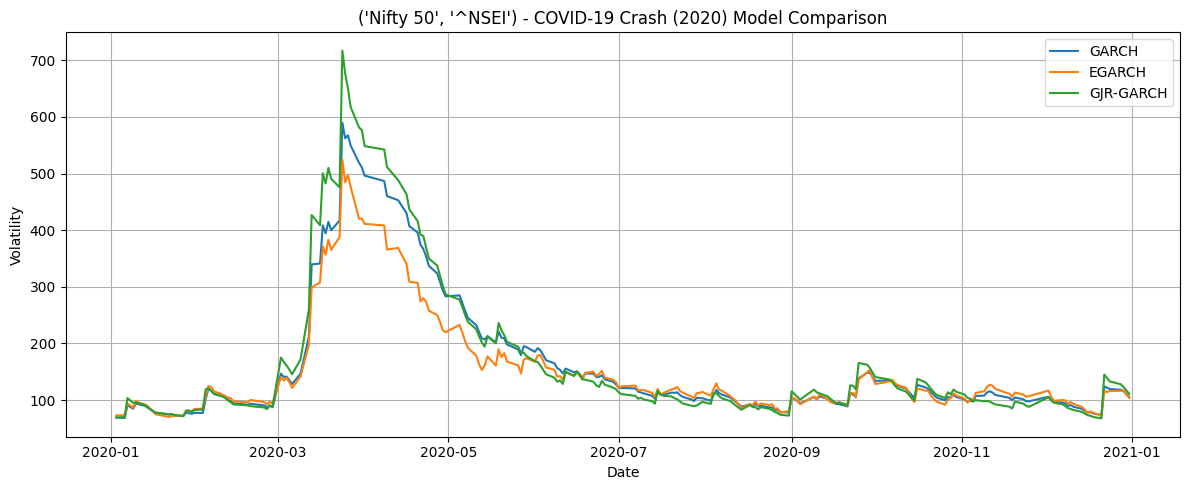

In [318]:
crisis_periods = {
    "Global Financial Crisis (2008-2009)": ('2008-01-01', '2009-12-31'),
    "COVID-19 Crash (2020)": ('2020-01-01', '2020-12-31')
}

for crisis_name, (start, end) in crisis_periods.items():
    for index_name in log_returns.columns:
        print(f"{crisis_name} - {index_name}")

        series = log_returns[index_name].dropna()
        arima_result, _ = select_best_arima(series)
        residuals = arima_result.resid.dropna()
        innovations = residuals * 100

        garch_model, _ = select_best_garch(innovations, vol_type='GARCH', o_value=0)
        egarch_model, _ = select_best_garch(innovations, vol_type='EGARCH', o_value=0)
        gjr_model, _ = select_best_garch(innovations, vol_type='GARCH', o_value=1)

        models = {
            'GARCH': garch_model,
            'EGARCH': egarch_model,
            'GJR-GARCH': gjr_model
        }

        plt.figure(figsize=(12, 5))
        for name, model in models.items():
            try:
                vol = model.conditional_volatility[start:end]
                plt.plot(vol, label=name)
            except Exception as e:
                print(f"{name} model failed for {index_name}: {e}")
                continue

        plt.title(f"{index_name} - {crisis_name} Model Comparison")
        plt.xlabel("Date")
        plt.ylabel("Volatility")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


Global Financial Crisis (2008-2009) - ('S&P 500', '^GSPC')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -23165.517362655046
Best GARCH order: (2, 0, 1) with AIC: 46968.00914902272


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best EGARCH order: (2, 0, 2) with AIC: 46984.717314039946
Best GARCH order: (1, 1, 1) with AIC: 46859.41490055733


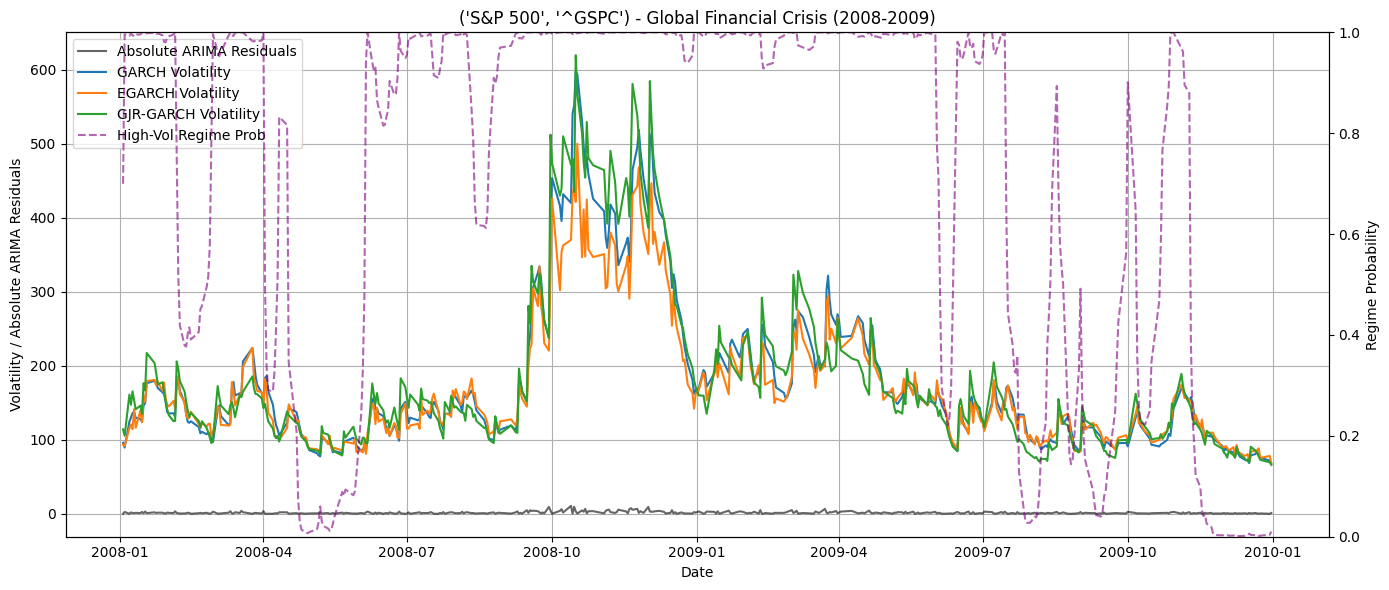

Global Financial Crisis (2008-2009) - ('NASDAQ', '^IXIC')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -22190.060929800704
Best GARCH order: (2, 0, 1) with AIC: 48497.014043751784


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.04e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.04e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohan

Best EGARCH order: (2, 0, 2) with AIC: 48519.00865765124
Best GARCH order: (2, 1, 1) with AIC: 48394.231703459795


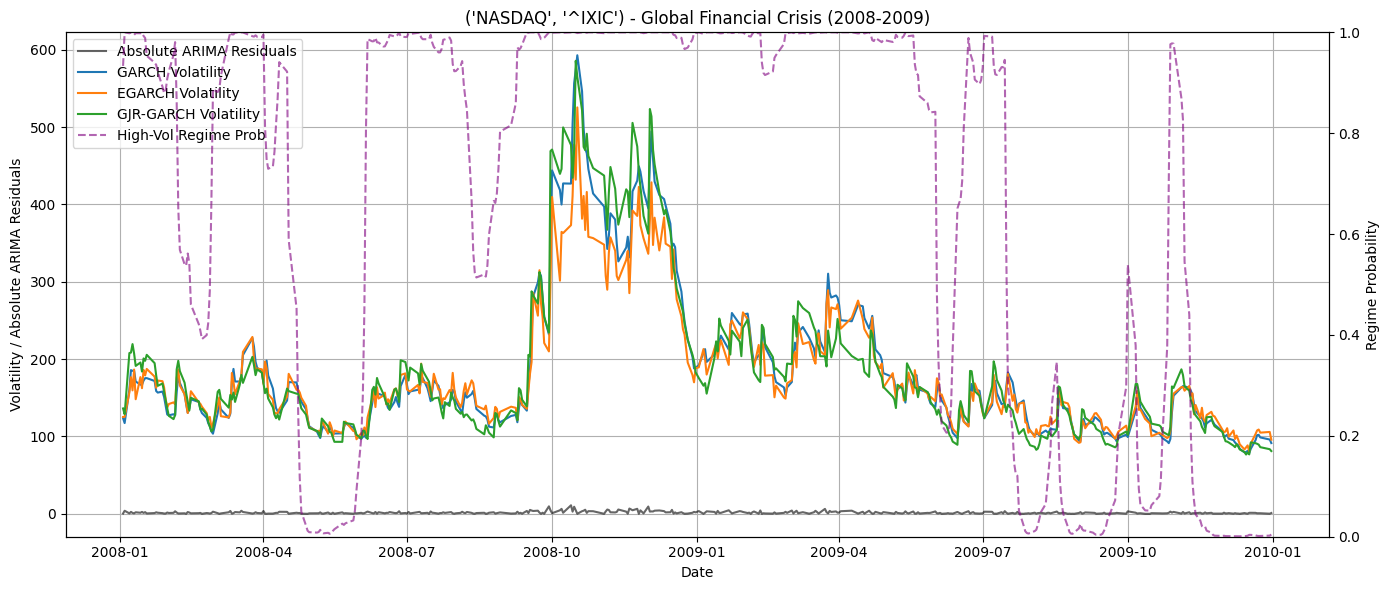

Global Financial Crisis (2008-2009) - ('Nifty 50', '^NSEI')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 0) with AIC: -22966.309486912236
Best GARCH order: (1, 0, 1) with AIC: 47584.33565019365


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best EGARCH order: (2, 0, 2) with AIC: 47595.38398831971
Best GARCH order: (1, 1, 1) with AIC: 47518.23810127875


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

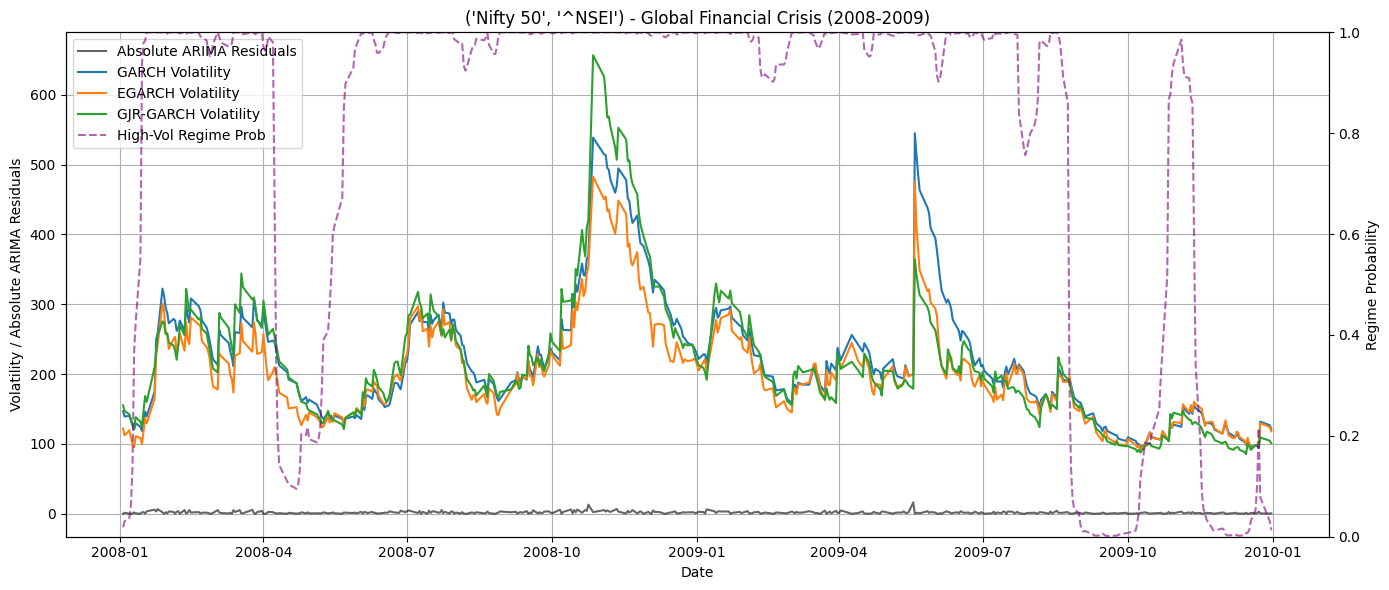

COVID-19 Crash (2020) - ('S&P 500', '^GSPC')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -23165.517362655046
Best GARCH order: (2, 0, 1) with AIC: 46968.00914902272


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best EGARCH order: (2, 0, 2) with AIC: 46984.717314039946
Best GARCH order: (1, 1, 1) with AIC: 46859.41490055733


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.591e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

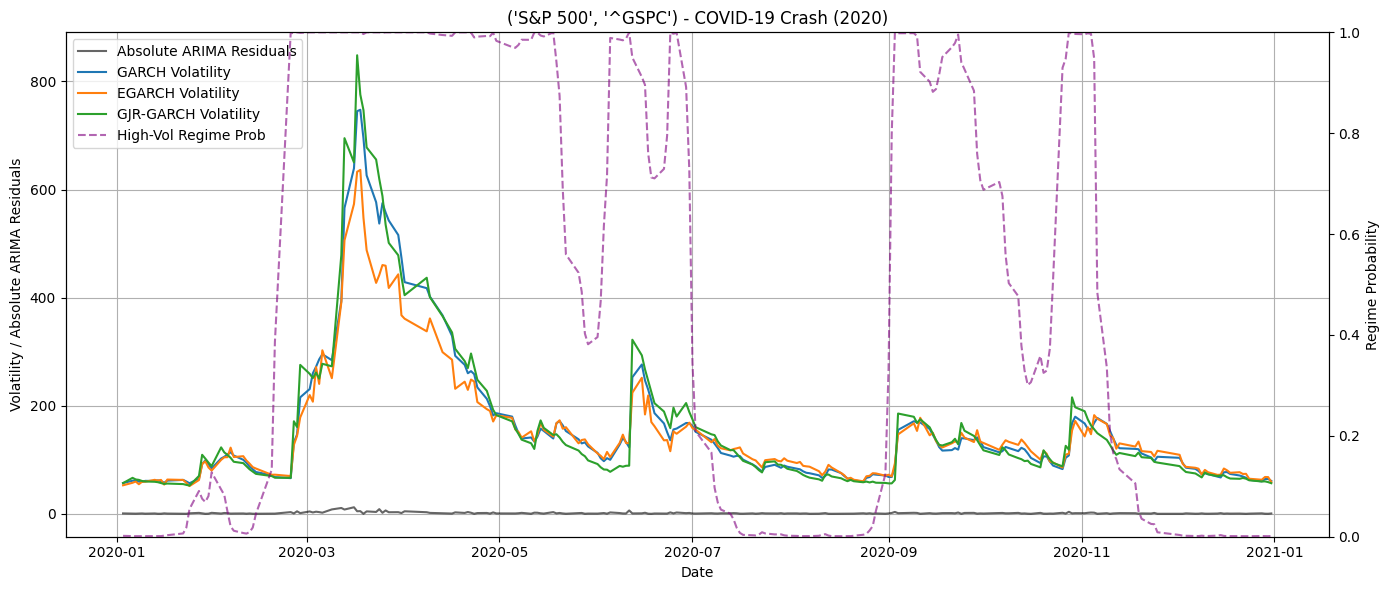

COVID-19 Crash (2020) - ('NASDAQ', '^IXIC')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 1) with AIC: -22190.060929800704
Best GARCH order: (2, 0, 1) with AIC: 48497.014043751784


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.04e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.04e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohan

Best EGARCH order: (2, 0, 2) with AIC: 48519.00865765124
Best GARCH order: (2, 1, 1) with AIC: 48394.231703459795


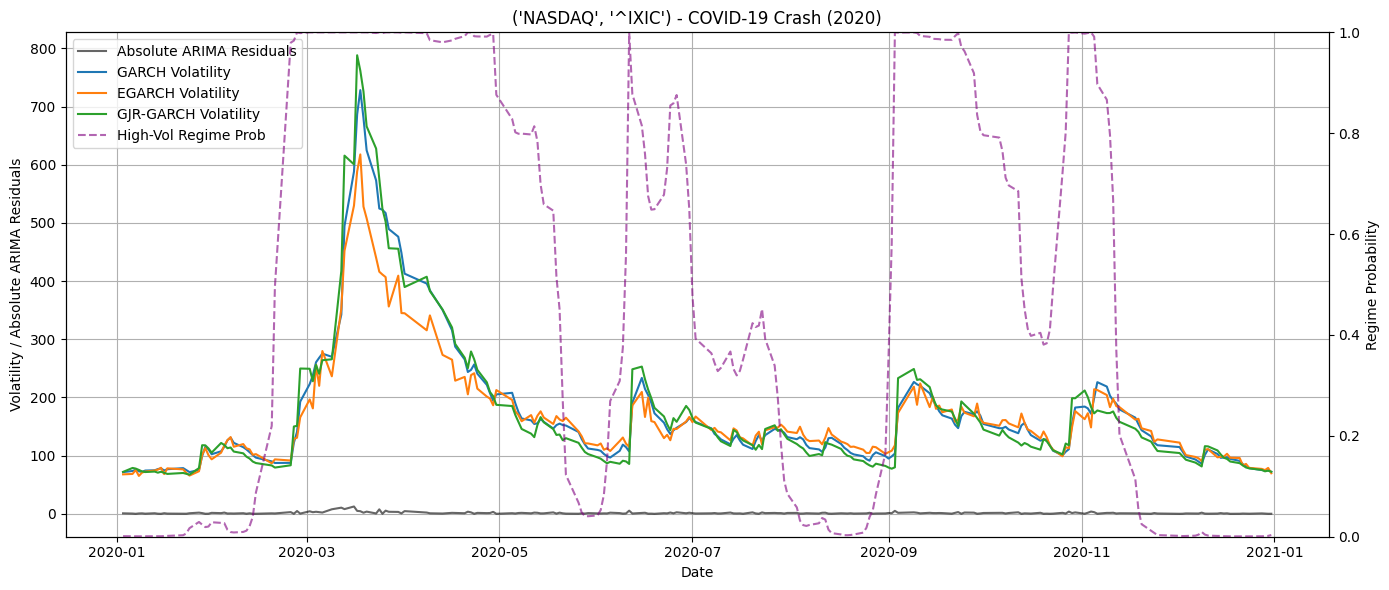

COVID-19 Crash (2020) - ('Nifty 50', '^NSEI')


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pro

Best ARIMA order: (0, 0, 0) with AIC: -22966.309486912236
Best GARCH order: (1, 0, 1) with AIC: 47584.33565019365


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

Best EGARCH order: (2, 0, 2) with AIC: 47595.38398831971
Best GARCH order: (1, 1, 1) with AIC: 47518.23810127875


/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsohani/Desktop/FinProject/venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.675e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/suyashsoh

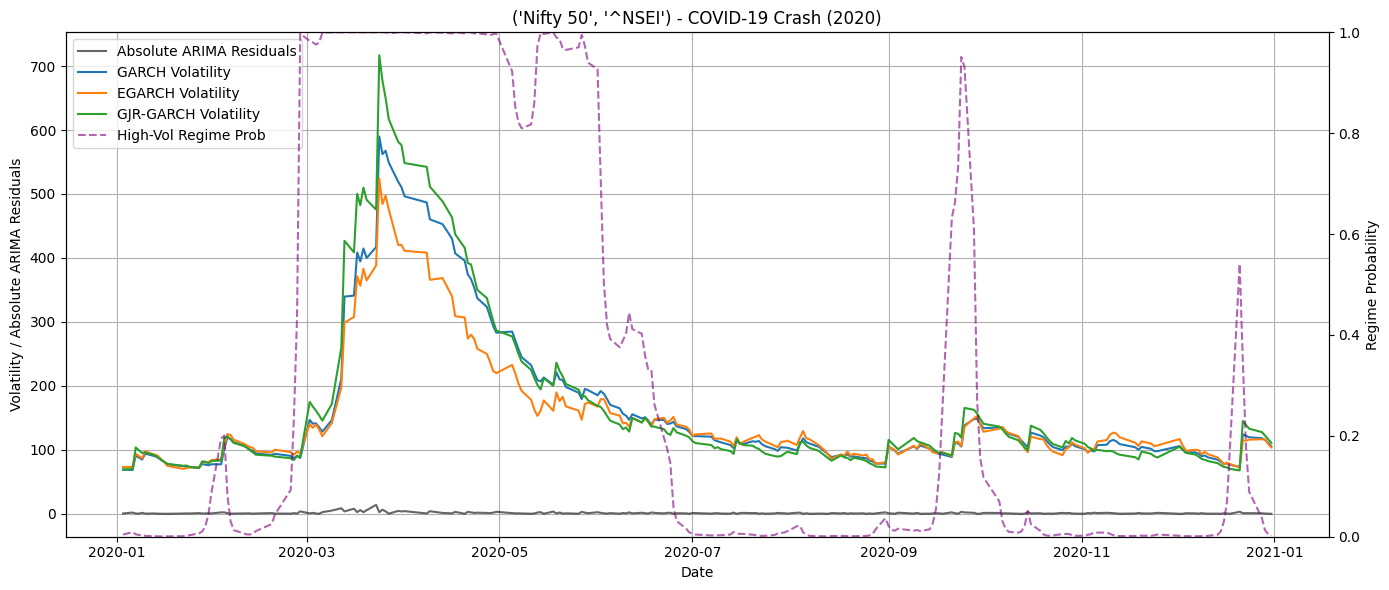

In [321]:
crisis_periods = {
    "Global Financial Crisis (2008-2009)": ('2008-01-01', '2009-12-31'),
    "COVID-19 Crash (2020)": ('2020-01-01', '2020-12-31')
}

for crisis_name, (start, end) in crisis_periods.items():
    for index_name in log_returns.columns:
        print(f"{crisis_name} - {index_name}")

        series = log_returns[index_name].dropna()
        arima_result, _ = select_best_arima(series)
        
        residuals = arima_result.resid.dropna()
        innovations = pd.Series(residuals * 100, index=residuals.index)
        absolute_residuals = np.abs(innovations.loc[start:end])

        garch_model, _ = select_best_garch(innovations, vol_type='GARCH', o_value=0)
        egarch_model, _ = select_best_garch(innovations, vol_type='EGARCH', o_value=0)
        gjr_model, _ = select_best_garch(innovations, vol_type='GARCH', o_value=1)

        models = {
            'GARCH': garch_model,
            'EGARCH': egarch_model,
            'GJR-GARCH': gjr_model
        }

        fig, ax1 = plt.subplots(figsize=(14, 6))
        ax1.plot(absolute_residuals, label="Absolute ARIMA Residuals", color='black', alpha=0.6, linewidth=1.5)

        for name, model in models.items():
            try:
                vol = model.conditional_volatility[start:end]
                ax1.plot(vol, label=f"{name} Volatility")
            except Exception as e:
                print(f"{name} model failed for {index_name}: {e}")
                continue

        ax1.set_ylabel("Volatility / Absolute ARIMA Residuals")
        ax1.set_xlabel("Date")
        ax1.grid(True)

        try:
            ms_model = MarkovAutoregression(innovations, k_regimes=2, order=1, trend='c', switching_variance=True)
            ms_results = ms_model.fit(disp=False)
            regime_prob = ms_results.smoothed_marginal_probabilities[1].loc[start:end]

            ax2 = ax1.twinx()
            ax2.plot(regime_prob, label="High-Vol Regime Prob", color='purple', linestyle='--', alpha=0.6)
            ax2.set_ylabel("Regime Probability")
            ax2.set_ylim(0, 1)

            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

        except Exception as e:
            print(f"Markov Switching failed for {index_name}: {e}")
            ax1.legend(loc='upper left')

        plt.title(f"{index_name} - {crisis_name}")
        plt.tight_layout()
        plt.show()
